## Linear Regression models

The dataset can be downloaded from theis page after you sign-up for the competition: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data. The dataset contains missing values, numerical and categorical columns. So, preprocessing the data to make it more suitable for linear regression is necessary.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from scipy.stats import skew
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_df = pd.read_csv('train.csv',index_col='Id')
test_df = pd.read_csv('test.csv',index_col='Id')
# train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index)
nrows = len(train_df)

categorical_cols_missing_train = [col for col in train_df.columns if train_df[col].isnull().any() and 
                                  train_df[col].dtype=='object']
train_df[categorical_cols_missing_train] = train_df[categorical_cols_missing_train].fillna('NotAvailable')

categorical_cols_missing_test = [col for col in test_df.columns if test_df[col].isnull().any() and 
                                 test_df[col].dtype=='object']
test_df[categorical_cols_missing_test] = test_df[categorical_cols_missing_test].fillna('NotAvailable')

cols_with_missing = [col for col in train_df.columns if train_df[col].isnull().any()]

#Observe the percentage of 'NotAvailable' entries in the categorical columns

print(dict(zip(categorical_cols_missing_train,
               [round(sum(train_df[col]=='NotAvailable')/nrows*100,2) for col in categorical_cols_missing_train])))

#Observe the percentage of 'NotAvailable' entries in the numerical columns

print(dict(zip(cols_with_missing,[round(train_df[col].isnull().sum()/len(train_df)*100,2) 
                                  for col in cols_with_missing if train_df[col].dtype in ['int64', 'float64']])))

{'BsmtQual': 2.53, 'GarageType': 5.55, 'PoolQC': 99.52, 'GarageCond': 5.55, 'BsmtCond': 2.53, 'BsmtFinType1': 2.53, 'Alley': 93.77, 'Electrical': 0.07, 'GarageQual': 5.55, 'BsmtExposure': 2.6, 'BsmtFinType2': 2.6, 'FireplaceQu': 47.26, 'GarageFinish': 5.55, 'MasVnrType': 0.55, 'Fence': 80.75, 'MiscFeature': 96.3}
{'LotFrontage': 17.74, 'GarageYrBlt': 5.55, 'MasVnrArea': 0.55}


Identify columns with most missing values and exclude them from the analysis

In [3]:
categ_cols_most_missing = [col for col in categorical_cols_missing_train 
                   if sum(train_df[col]=='NotAvailable')/nrows>0.5]
X_train_data = train_df.drop(['SalePrice'],axis=1)
y_train_data = train_df['SalePrice']
categorical_cols = [col for col in set(X_train_data.columns) - set(categ_cols_most_missing) if
                    X_train_data[col].dtype == "object"]
numerical_cols = [col for col in X_train_data if X_train_data[col].dtype in ['int64', 'float64']]

Next, the missing values are imputed. The categories are one-hot encoded.

In [4]:
numerical_pp = SimpleImputer()

categorical_pp = Pipeline(steps=[
    ('oh', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pp, numerical_cols),
        ('cat', categorical_pp, categorical_cols)
    ])

In [5]:
my_model = LinearRegression()
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', my_model)])
my_pipeline.fit(X_train_data, y_train_data)
preds = my_pipeline.predict(test_df)
solution = pd.DataFrame({"id":test_df.index, "SalePrice":preds})
solution.to_csv("lin_sol.csv", index = False)

Let us make the dataset more suitable for linear regression

In [6]:
skewed_cols = X_train_data[numerical_cols].apply(
    lambda x: abs(skew(x.dropna())))>0.75
skewed_cols = skewed_cols[skewed_cols].index
X_train_data[skewed_cols] = np.log1p(X_train_data[skewed_cols])
y_train_data = np.log1p(y_train_data)
test_df[skewed_cols] = np.log1p(test_df[skewed_cols])
my_model = LinearRegression()
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', my_model)])
my_pipeline.fit(X_train_data, y_train_data)
preds = np.expm1(my_pipeline.predict(test_df))
solution = pd.DataFrame({"id":test_df.index, "SalePrice":preds})
solution.to_csv("lin_sol.csv", index = False)

Let us compare various linear models and pick out the best one. The score was less than top 50%.

In [7]:
my_model = LinearRegression()
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', my_model)
                             ])
rmse = np.sqrt(-cross_val_score(my_pipeline, X_train_data, y_train_data, 
                                scoring="neg_mean_squared_error", cv = 5))
print('LinearRegression:', rmse.mean())
my_model = RidgeCV(alphas=[0.01,0.1,0.5,1,2,4,6,8])
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', my_model)
                             ])
rmse = np.sqrt(-cross_val_score(my_pipeline, X_train_data, y_train_data, 
                                scoring="neg_mean_squared_error", cv = 5))
print('RidgeCV:', rmse.mean())
my_model = LassoCV(alphas=[0.01,0.1,0.5,1,2])
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', my_model)
                             ])
rmse = np.sqrt(-cross_val_score(my_pipeline, X_train_data, y_train_data, 
                                scoring="neg_mean_squared_error", cv = 5))
print('LassoCV:',rmse.mean())

LinearRegression: 0.13887133018810266
RidgeCV: 0.1285833616511126
LassoCV: 0.15381664910296816


RidgeCV performs better but why not LassoCV? Are all the features important?
The score improved to nearly top 30%.

In [8]:
my_model = RidgeCV(alphas=[0.01,0.1,0.5,1,2,4,6,8])
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', my_model)])
my_pipeline.fit(X_train_data, y_train_data)
preds = np.expm1(my_pipeline.predict(test_df))
solution = pd.DataFrame({"id":test_df.index, "SalePrice":preds})
solution.to_csv("lin_sol.csv", index = False)

Next an outlier is detected in the training dataset which may not generalize the model well. This point was realized after referring to: https://www.kaggle.com/lucasgiutavares/easy-modelling-with-lasso-gbm-regression-top-19 and observing the numerical features against the sales price.

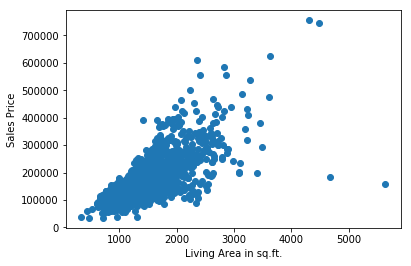

In [9]:
plt.scatter(train_df['GrLivArea'],train_df['SalePrice'])
plt.xlabel('Living Area in sq.ft.')
plt.ylabel('Sales Price')

The outliers are removed and the predictions are obtained again the score on the test dataset improves to top 25%.

In [10]:
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index)
X_train_data = train_df.drop(['SalePrice'],axis=1)
y_train_data = train_df['SalePrice']
skewed_cols = X_train_data[numerical_cols].apply(
    lambda x: abs(skew(x.dropna())))>0.75
skewed_cols = skewed_cols[skewed_cols].index
X_train_data[skewed_cols] = np.log1p(X_train_data[skewed_cols])
y_train_data = np.log1p(y_train_data)
test_df[skewed_cols] = np.log1p(test_df[skewed_cols])
my_model = RidgeCV(alphas=[0.01,0.1,0.5,1,2,4,6,8])
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', my_model)])
my_pipeline.fit(X_train_data, y_train_data)
preds = np.expm1(my_pipeline.predict(test_df))
solution = pd.DataFrame({"id":test_df.index, "SalePrice":preds})
solution.to_csv("lin_sol.csv", index = False)